<h1 style="font-family: 'American Typewriter', sans-serif"> <b>
    Análisis de patrones de desigualdad de ingresos
</b> </h1>

<p style="font-family: 'Brush Script MT', cursive; font-size: 24px;" align="right">
Francisco Chaux Guzmán
</p>

# Preparación del entorno de trabajo

Se hace la carga de las librerías necesarias.

In [13]:
# procesamiento de datos
import numpy as np
import pandas as pd

# visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preparación de los datos

Se realiza la importación de la [información mundial sobre desigualdad de ingresos](https://www.kaggle.com/datasets/mannmann2/world-income-inequality-database).

In [14]:
# lectura de los datos
datos_desigualdad = pd.read_csv('../datos/WIID_06MAY2020.csv')
# revisión de las primeras observaciones
datos_desigualdad.head()

,Unnamed: 0,id,country,c3,c2,year,gini_reported,palma,ratio_top20bottom20,bottom40,...,gdp_ppp_pc_usd2011,population,revision,quality,quality_score,source,source_detailed,source_comments,survey,link
0,0,1,Afghanistan,AFG,AF,2008,29.00,NaN,4.33,22.00,...,1268.0,27722282.0,New 2019,High,12,National statistical authority,European Union and the Central Statistics Orga...,NaN,Living Conditions Survey (LCS),https://cso-of-afghanistan.shinyapps.io/ALCS_D...
1,1,2,Afghanistan,AFG,AF,2012,33.00,NaN,4.11,23.00,...,1773.0,31161378.0,New 2019,High,12,National statistical authority,European Union and the Central Statistics Orga...,NaN,Living Conditions Survey (LCS),https://cso-of-afghanistan.shinyapps.io/ALCS_D...
2,2,3,Afghanistan,AFG,AF,2017,31.00,NaN,4.44,22.00,...,1758.0,36296108.0,New 2019,High,12,National statistical authority,European Union and the Central Statistics Orga...,NaN,Living Conditions Survey (LCS),https://eeas.europa.eu/regions/asia/44072/resu...
3,3,4,Albania,ALB,AL,1996,27.01,0.93,3.95,22.85,...,4635.0,3098699.0,New 2019,Average,13,World Bank,World Bank 2019,PovcalNet,NaN,http://iresearch.worldbank.org/PovcalNet/povOn...
4,4,5,Albania,ALB,AL,2002,31.74,1.22,4.83,20.93,...,6088.0,3126183.0,New 2019,Average,13,World Bank,World Bank 2019,PovcalNet,NaN,http://iresearch.worldbank.org/PovcalNet/povOn...


También se revisa la estructura general de la base. Debido a que son muchas variables, por el momento se excluye su listado (con `verbose=False`) y, en su lugar, se seleccionan las variables que se van a utilizar (para esto se usa el [diccionario](https://www.wider.unu.edu/sites/default/files/WIID/PDF/WIID-User_Guide_06MAY2020.pdf)) y se revisan con mayor profundidad.

In [15]:
datos_desigualdad.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11826 entries, 0 to 11825
Columns: 60 entries, Unnamed: 0 to link
dtypes: float64(28), int64(4), object(28)
memory usage: 5.4+ MB


Se tienen 11,826 observaciones y 60 variables, de las cuales 28 son numéricas continuas, 4 son númericas enteras y 28 son de tipo texto.

Con base en el diccionario, se seleccionan las siguientes variables para su análisis:

- `id`. Identificador.
- `country`. País o área.
-  `year`. Año. En este caso, cuando una encuesta se prolonga durante más de un año, se considera
el año en que finaliza.
- `gini_reported`. El coeficiente de Gini tal y como es reportado por la fuente.
- `palma`. La razón de Palma.
- `incomegroup`. Clasificación del país según su clasificación de ingreso en el Banco Mundial.
- `population`. Población del país, de acuerdo a proyecciones de la ONU.

In [16]:
datos_desigualdad = datos_desigualdad[[
    'id', 'country', 'year', 'gini_reported', 'palma', 'incomegroup', 'population'
    ]]

Hecha la selección, se vuelve a revisar la estructura.

In [17]:
datos_desigualdad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11826 entries, 0 to 11825
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             11826 non-null  int64  
 1   country        11826 non-null  object 
 2   year           11826 non-null  int64  
 3   gini_reported  11747 non-null  float64
 4   palma          6714 non-null   float64
 5   incomegroup    11826 non-null  object 
 6   population     11765 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 646.9+ KB


Lo primero que se nota es la presencia de varies faltantes en el coeficiente de Gini, la razón de Palma y la población.

Debido a que los análisis se sentrarán en el coeficiente de Gini, se eliminan los faltantes en esa variable y se revisa cómo queda.

In [18]:
datos_desigualdad = datos_desigualdad.dropna(subset=['gini_reported'])
datos_desigualdad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11747 entries, 0 to 11825
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             11747 non-null  int64  
 1   country        11747 non-null  object 
 2   year           11747 non-null  int64  
 3   gini_reported  11747 non-null  float64
 4   palma          6676 non-null   float64
 5   incomegroup    11747 non-null  object 
 6   population     11686 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 734.2+ KB


Ya no hay faltantes en las variables. Se dejan los otros faltantes para no perder tanta información.

Ahora, se revisa la presencia de observaciones duplicadas.

In [19]:
if datos_desigualdad.duplicated().any()==False:
    print("No hay observaciones duplicadas")
else:
    print("Hay observaciones duplicadas")

No hay observaciones duplicadas


Por otra parte, se revisa el comportamiento de las variables numéricas.

In [20]:
datos_desigualdad.describe().style.format("{:,.2f}")

,id,year,gini_reported,palma,population
count,"11,747.00","11,747.00","11,747.00","6,676.00","11,686.00"
mean,"5,914.49","1,996.01",38.23,2.18,"78,849,194.14"
std,"3,407.60",15.85,10.20,1.65,"211,861,346.94"
min,1.00,"1,867.00",12.10,0.55,"10,521.00"
25%,"2,970.50","1,988.00",30.30,1.15,"5,244,036.00"
50%,"5,913.00","1,999.00",36.48,1.61,"15,262,754.00"
75%,"8,862.50","2,009.00",46.00,2.81,"56,542,434.00"
max,"11,826.00","2,018.00",78.60,39.81,"1,421,021,696.00"


Es de notar que variables como el Gini no aparecen en el formato correcto, ya que debería ser menor a cero y estar a tres digitos. Se corrige con la siguiente línea.

In [24]:
datos_desigualdad['gini_reported'] = datos_desigualdad['gini_reported'] / 100
datos_desigualdad['gini_reported'].describe()

count    11747.000000
mean         0.382326
std          0.102028
min          0.121000
25%          0.303000
50%          0.364800
75%          0.460000
max          0.786000
Name: gini_reported, dtype: float64

De esta forma, se proceden a los análisis siguientes.

# Visualizaciones

## Distribución de los coeficientes de Gini

Se inicia revisan la distribución del valor del coeficiente de Gini. La concentración es alta entre 0.3 y 0.4, con una censura general hacia la izquierda de la distribución. Esto parece significar que, en general, no se presentan valores tan altos como los que podrían pensarse en principio.

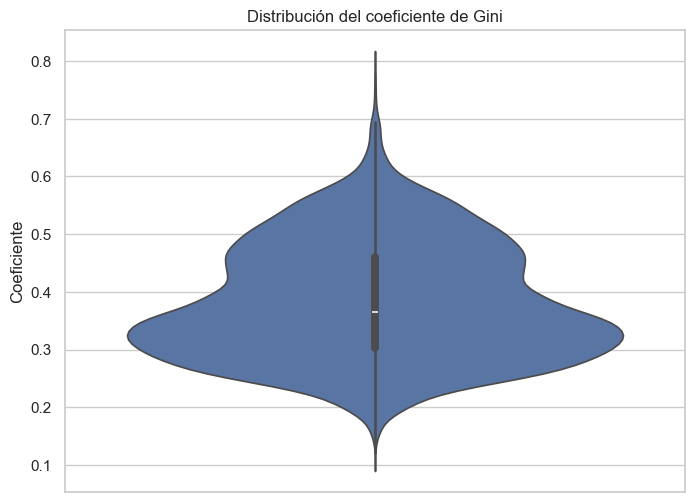

In [25]:
# creación del espacio para el gráfico

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# generación del gráfico

sns.violinplot(data=datos_desigualdad, y='gini_reported')

# títulos y etiquetas

plt.title('Distribución del coeficiente de Gini')
plt.xlabel('')
plt.ylabel('Coeficiente')

# impresión del gráfico
plt.show()

Al revisar la distribución por grupo de ingresos, se ven algunas diferencias. Los países de ingreso alto tienen a tener valores de Gini más bajos, con una concentración más cercana a 0.3. Los valores más altos se evidencian en los países de ingreso medio alto, cercanos al 0.5. Le siguen los países de ingreso bajo y, cerca a los países de ingreso alto, aquellos de ingreso medio bajo.

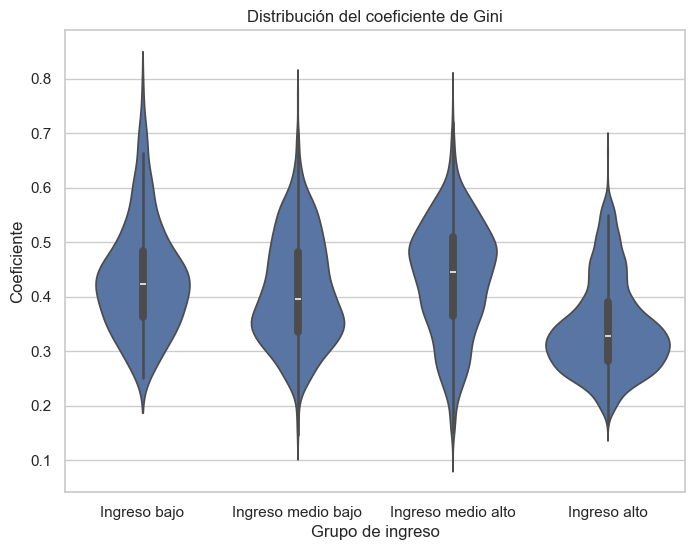

In [32]:
# creación de grupos de ingreso en español

dict_grupoingreso = {
    'Low income': 'Ingreso bajo',
    'Lower middle income': 'Ingreso medio bajo',
    'Upper middle income': 'Ingreso medio alto',
    'High income': 'Ingreso alto'
}
datos_desigualdad['grupoingreso'] = datos_desigualdad['incomegroup'].map(dict_grupoingreso)

# definición de orden de las categorías

orden_categorias = [
    'Ingreso bajo',
    'Ingreso medio bajo',
    'Ingreso medio alto',
    'Ingreso alto'
]

# creación del espacio para el gráfico

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# generación del gráfico

sns.violinplot(data=datos_desigualdad, x = 'grupoingreso', y='gini_reported', order=orden_categorias)

# títulos y etiquetas

plt.title('Distribución del coeficiente de Gini')
plt.xlabel('Grupo de ingreso')
plt.ylabel('Coeficiente')

# impresión del gráfico
plt.show()